<a href="https://colab.research.google.com/github/abar-1/SDR-ML-Project/blob/main/MentalHealth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the uploaded Excel file and inspect the first rows
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_excel('/content/drive/MyDrive/Mental_HealthSentiment_Analysis/data.xlsx')
df.head()

,id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.columns = [str(c).strip() for c in df.columns]
print(df.head())
print(df.shape)

# Basic missingness check
missing_counts = df.isna().sum()
print(missing_counts)

   id                                          statement   status
0   0                                         oh my gosh  Anxiety
1   1  trouble sleeping, confused mind, restless hear...  Anxiety
2   2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3   3  I've shifted my focus to something else but I'...  Anxiety
4   4  I'm restless and restless, it's been a month n...  Anxiety
(53043, 3)
id             0
statement    375
status         0
dtype: int64


In [8]:
# Compute sentiment using VADER (good for short, informal text) and summarize by mental-health status
import numpy as np
from tqdm import tqdm

%pip -q install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

text_vals = df["statement"].fillna("").astype(str).values

sent_pos = []
sent_neu = []
sent_neg = []
sent_comp = []

for t in tqdm(text_vals, total=len(text_vals)):
    s = analyzer.polarity_scores(t)
    sent_pos.append(s["pos"])
    sent_neu.append(s["neu"])
    sent_neg.append(s["neg"])
    sent_comp.append(s["compound"])

sent_df = df.copy()
sent_df["sent_pos"] = np.array(sent_pos)
sent_df["sent_neu"] = np.array(sent_neu)
sent_df["sent_neg"] = np.array(sent_neg)
sent_df["sent_compound"] = np.array(sent_comp)

# Standard sentiment buckets based on compound score
sent_df["sentiment_label"] = pd.cut(
    sent_df["sent_compound"],
    bins=[-1.0001, -0.05, 0.05, 1.0001],
    labels=["negative", "neutral", "positive"]
).astype(str)

# Overall summary
overall_summary = sent_df[["sent_pos","sent_neu","sent_neg","sent_compound"]].describe()
print(overall_summary)

# By mental-health status
status_summary = sent_df.groupby("status")["sent_compound"].agg(
    count="count",
    mean="mean",
    median="median",
    std="std",
    p10=lambda s: float(np.nanpercentile(s, 10)),
    p90=lambda s: float(np.nanpercentile(s, 90))
).sort_values("count", ascending=False)
print(status_summary.head(20))

# Sentiment label distribution by status
label_dist = (
    sent_df.groupby(["status","sentiment_label"]).size()
    .reset_index(name="n")
)
label_dist["pct_within_status"] = label_dist.groupby("status")["n"].transform(lambda s: 100.0 * s / s.sum())
print(label_dist.head(15))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


100%|██████████| 53043/53043 [01:04<00:00, 823.42it/s]


           sent_pos      sent_neu      sent_neg  sent_compound
count  53043.000000  53043.000000  53043.000000   53043.000000
mean       0.114096      0.740082      0.138751      -0.198741
std        0.114316      0.158554      0.121420       0.667513
min        0.000000      0.000000      0.000000      -0.999900
25%        0.034000      0.667000      0.041000      -0.879300
50%        0.095000      0.744000      0.130000      -0.258400
75%        0.154000      0.822000      0.199000       0.381800
max        1.000000      1.000000      1.000000       0.999700
                      count      mean  median       std      p10      p90
status                                                                   
Normal                16351  0.098279  0.0000  0.427528 -0.49390  0.70030
Depression            15404 -0.330207 -0.7092  0.725262 -0.98540  0.90427
Suicidal              10653 -0.441745 -0.8000  0.662998 -0.98880  0.77278
Anxiety                3888 -0.353768 -0.6124  0.662389 -0.9822

                 status      n
0                Normal  16351
1            Depression  15404
2              Suicidal  10653
3               Anxiety   3888
4               Bipolar   2877
5                Stress   2669
6  Personality disorder   1201


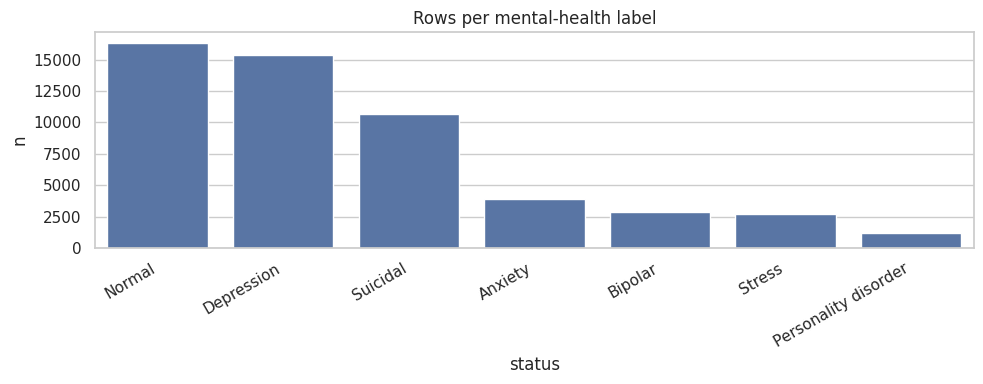

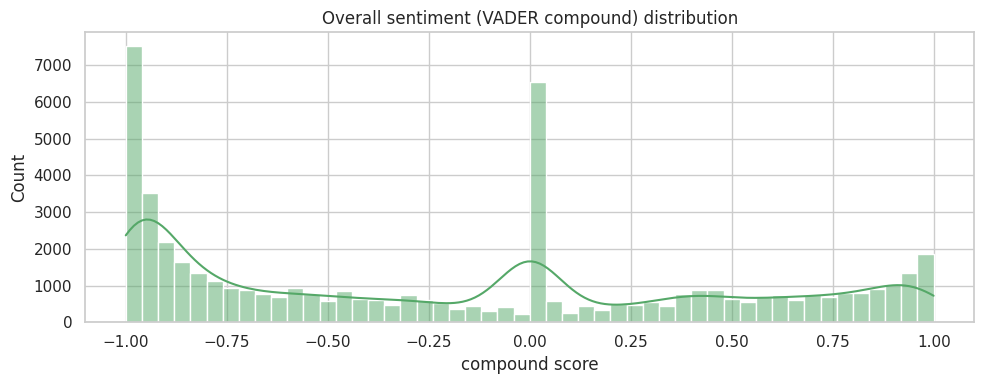

                          n  mean_compound  median_compound    neg_pct  \
status                                                                   
Normal                16351       0.098279           0.0000  24.977066   
Depression            15404      -0.330207          -0.7092  67.677227   
Suicidal              10653      -0.441745          -0.8000  73.613067   
Anxiety                3888      -0.353768          -0.6124  70.601852   
Bipolar                2877      -0.091545          -0.1969  51.720542   
Stress                 2669      -0.238611          -0.4917  61.371300   
Personality disorder   1201      -0.067180           0.0000  46.711074   

                        neu_pct    pos_pct  
status                                      
Normal                34.297596  40.725338  
Depression             2.239678  30.083095  
Suicidal               3.135267  23.251666  
Anxiety                2.880658  26.517490  
Bipolar                5.978450  42.301008  
Stress            

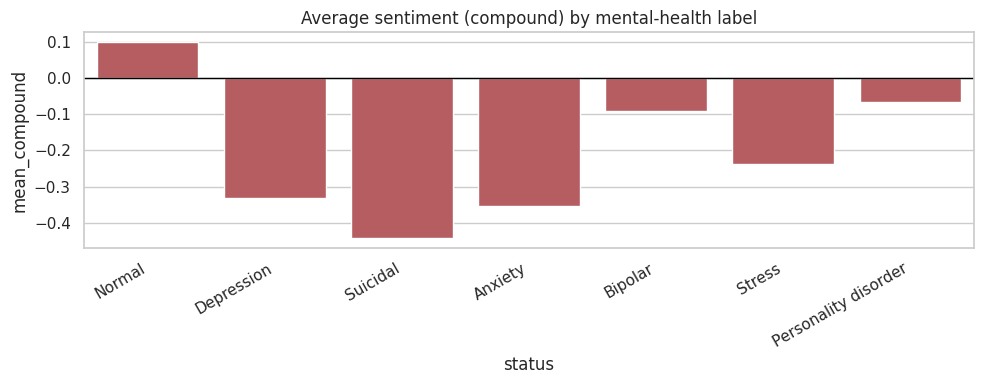

sentiment_label        negative    neutral   positive
status                                               
Anxiety               70.601852   2.880658  26.517490
Bipolar               51.720542   5.978450  42.301008
Depression            67.677227   2.239678  30.083095
Normal                24.977066  34.297596  40.725338
Personality disorder  46.711074  13.322231  39.966694
Stress                61.371300   5.133009  33.495691
Suicidal              73.613067   3.135267  23.251666


<Figure size 1000x500 with 0 Axes>

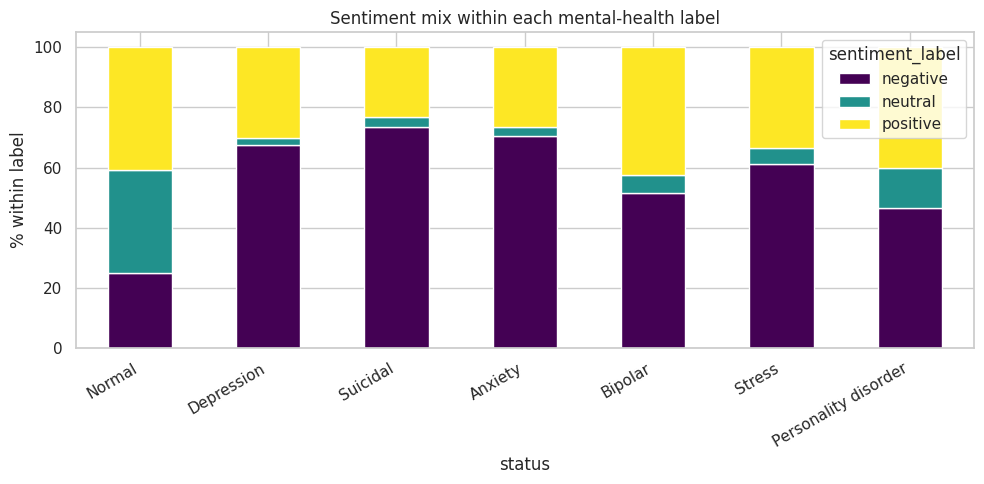

mental_health_sentiment_enriched.csv


In [9]:
# Create plots and a compact report table, then export enriched dataset
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Status counts
status_counts = sent_df["status"].value_counts().reset_index()
status_counts.columns = ["status", "n"]
print(status_counts.head(20))

plt.figure(figsize=(10,4))
sns.barplot(data=status_counts, x="status", y="n", color="#4C72B0")
plt.xticks(rotation=30, ha="right")
plt.title("Rows per mental-health label")
plt.tight_layout()
plt.show()

# Sentiment compound distribution overall
plt.figure(figsize=(10,4))
sns.histplot(sent_df["sent_compound"], bins=50, kde=True, color="#55A868")
plt.title("Overall sentiment (VADER compound) distribution")
plt.xlabel("compound score")
plt.tight_layout()
plt.show()

# Mean compound by status
status_summary2 = sent_df.groupby("status").agg(
    n=("sent_compound","count"),
    mean_compound=("sent_compound","mean"),
    median_compound=("sent_compound","median"),
    neg_pct=("sentiment_label", lambda s: 100.0 * (s=="negative").mean()),
    neu_pct=("sentiment_label", lambda s: 100.0 * (s=="neutral").mean()),
    pos_pct=("sentiment_label", lambda s: 100.0 * (s=="positive").mean()),
)
status_summary2 = status_summary2.sort_values("n", ascending=False)
print(status_summary2)

plt.figure(figsize=(10,4))
sns.barplot(data=status_summary2.reset_index(), x="status", y="mean_compound", color="#C44E52")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=30, ha="right")
plt.title("Average sentiment (compound) by mental-health label")
plt.tight_layout()
plt.show()

# Stacked sentiment label distribution by status
label_pivot = (sent_df.groupby(["status","sentiment_label"]).size().unstack(fill_value=0))
label_pct = label_pivot.div(label_pivot.sum(axis=1), axis=0) * 100.0
label_pct = label_pct[[c for c in ["negative","neutral","positive"] if c in label_pct.columns]]
print(label_pct.head(10))

plt.figure(figsize=(10,5))
label_pct.loc[status_summary2.index].plot(kind="bar", stacked=True, figsize=(10,5), colormap="viridis")
plt.xticks(rotation=30, ha="right")
plt.ylabel("% within label")
plt.title("Sentiment mix within each mental-health label")
plt.tight_layout()
plt.show()

# Export enriched dataset
out_path = "mental_health_sentiment_enriched.csv"
sent_df.to_csv(out_path, index=False)
print(out_path)